In [6]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(106, 100, 100, 3)
(106, 4, 4)
(106, 4, 4)


array([[-9.3054223e-01,  1.1707554e-01, -3.4696460e-01, -1.3986591e+00],
       [-3.6618456e-01, -2.9751042e-01,  8.8170075e-01,  3.5542498e+00],
       [ 7.4505806e-09,  9.4751304e-01,  3.1971723e-01,  1.2888215e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

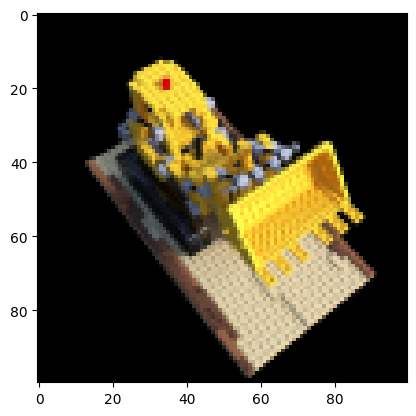

In [29]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

plt.imshow(images[3])
poses[12]
print(images.shape)
print(poses.shape)
print(poses.shape)

poses[1]

In [8]:
image = plt.imread("nature1.png")
image_tensor = torch.tensor(image)
image_tensor.shape

torch.Size([301, 313, 4])

In [11]:
x = image_tensor.shape[0]
y = image_tensor.shape[1]
size = min(x, y)

# crop to square
image_tensor = image_tensor[:size, :size, :3]
image_tensor.shape

torch.Size([301, 301, 3])

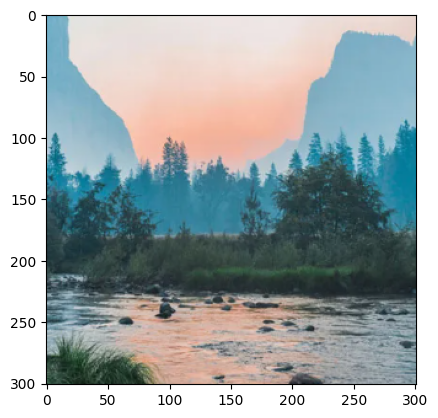

In [12]:
plt.imshow(image_tensor)

In [13]:
numberOfFor = 2
model = nn.Sequential(
	nn.Linear(2*numberOfFor, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 3),
	nn.Sigmoid(),
)
model  = model.to(device)

In [14]:
import math

X = torch.tensor(
	[[
		math.sin(math.pi * 2**i * x/size) for i in range(numberOfFor)
	] +
	[
		math.cos(math.pi * 2**i * y/size) for i in range(numberOfFor)
	]
	for x in range(size) for y in range(size)], device=device)



Y = torch.tensor([image_tensor[x,y].tolist() for x in range(size) for y in range(size)], device=device)

print(X.shape)
print(Y.shape)


torch.Size([90601, 4])
torch.Size([90601, 3])


In [15]:
def get_image():
	with torch.no_grad():
		# output = torch.zeros((size, size, 3))
		output = model(X)
		output = output.reshape(size, size, 3)
		output = output.to("cpu")
		return output


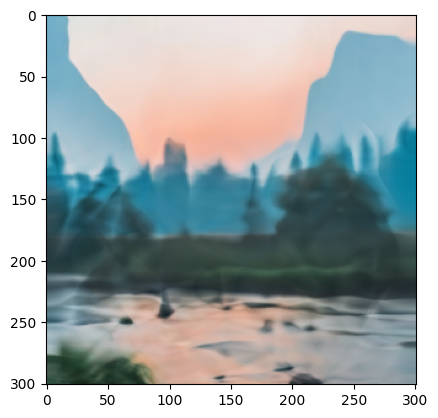

Loss is 0.0016113132005557418: 100%|██████████| 10000/10000 [59:36<00:00,  2.80it/s]


In [16]:
epochs = 10000
from tqdm import tqdm
from IPython.display import clear_output
def loss_fn(output, target):
		loss = torch.mean((output - target)**2)
		return loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(epochs))
# pbar = range(epochs)

image_display = None

fig = plt.figure()
ax = fig.gca()
for n in pbar:
    preds = model(X)
    loss = loss_fn(preds, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description( f"Loss is {loss}")

    if(n % 10 == 0):
        clear_output()
        image  = get_image()
        plt.imshow(image)
        # if not image_display:
            # image_display = ax.imshow(image)
            # image_display = plt.imshow(image)
            # plt.show()
        # image_display.set_data(image)
        plt.show()
        # fig.canvas.draw()
        # fig.show()
        # image_display.draw()
		

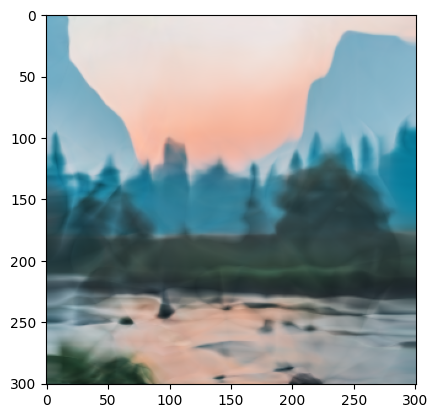

In [17]:
image  = get_image()
plt.imshow(image)